In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
import quandl
import seaborn as sns
import sys
import pandas_datareader.data as web
from statsmodels.graphics.tsaplots import plot_acf

Implement gold Model from eddy elfenbin and alpeh blog to see how they have perfroemd out of sample. It would be a good idea to get a frame work on how to think about. 

In [2]:
# Gold
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold_daily = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_daily.columns = ['Gold']

Gold_monthly = Gold_daily.resample('M').last()
Gold_monthly .index = Gold_monthly .index + pd.Timedelta('1 day')
Gold_monthly.columns = ['Gold']

In [3]:
# TBill rate and CPI

CPI_tmp = web.DataReader('CPIAUCSL','fred', '1970-01-01') # Monthly
TBILL_tmp = web.DataReader('DGS3MO','fred', '1970-01-01') # Monthly
deflator_tmp = web.DataReader('USAGDPDEFQISMEI','fred', '1970-01-01')
rate_10yr_tmp= web.DataReader('DGS10','fred', '1970-01-01')
real_rate_tmp = web.DataReader('DFII10','fred', '1970-01-01')

In [32]:
TBILL = TBILL_tmp.resample('M').last()
TBILL.index = TBILL.index + pd.Timedelta('1 day')

rate_10yr = rate_10yr_tmp.resample('M').last()
rate_10yr.index = rate_10yr.index + pd.Timedelta('1 day')


CPI_12m = (CPI_tmp.pct_change(12)*100)

df = pd.concat([TBILL, CPI_12m, Gold_monthly, deflator_tmp, CPI_tmp,rate_10yr ],axis =1)
df.columns = ["TBILL", "CPI_12m", "Gold", "deflator", 'CPI', '10yr']

df['Real Rate'] = df['TBILL'] - df['CPI_12m']
df['Real 10yr'] = df['10yr'] - df['CPI_12m']


df =df.dropna()

## Simple Gold Model

simple model from eddy elfenbein

Evaluation:Worthless model

In [5]:
gold_model = ((2 - (df['Real Rate']))/12)*8

In [6]:
gold_model =((gold_model/100)+1).cumprod() * 426

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


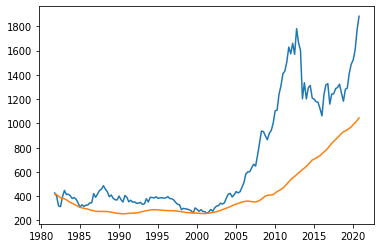

In [7]:
plt.plot(df['Gold']);
plt.plot(gold_model);

## Real Rates and 5 year future return

In [25]:
y = 5


df_fut = pd.concat([TBILL, CPI_12m, Gold_monthly, CPI_tmp, rate_10yr_tmp],axis =1)
df_fut.columns = ["TBILL", "CPI_12m", "Gold", 'CPI', '10YR']

df_fut['Real Rate'] = df_fut['TBILL'] - df_fut['CPI_12m']
df_fut['Normal Gold'] = df_fut['Gold']/df_fut['CPI']
df_fut['Real 10YR']  = df_fut['10YR'] - df_fut['CPI_12m']

df_fut['gold_fut_ret'] = df_fut['Gold'].pct_change(12 * y)

df_fut['gold_fut_ret'] = df_fut['gold_fut_ret'].shift(-12*y)

,TBILL,CPI_12m,Gold,CPI,10YR,Real Rate,Normal Gold,Real 10YR,gold_fut_ret
1968-02-01,NaN,NaN,35.20,NaN,NaN,NaN,NaN,NaN,-0.006250
1968-03-01,NaN,NaN,35.20,NaN,NaN,NaN,NaN,NaN,-0.006250
1968-04-01,NaN,NaN,35.20,NaN,NaN,NaN,NaN,NaN,-0.006250
1968-05-01,NaN,NaN,39.10,NaN,NaN,NaN,NaN,NaN,-0.105371
1968-06-01,NaN,NaN,42.00,NaN,NaN,NaN,NaN,NaN,-0.167143
...,...,...,...,...,...,...,...,...,...
2021-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-16,NaN,NaN,NaN,NaN,1.30,NaN,NaN,NaN,NaN
2021-02-17,NaN,NaN,NaN,NaN,1.29,NaN,NaN,NaN,NaN
2021-02-18,NaN,NaN,NaN,NaN,1.29,NaN,NaN,NaN,NaN


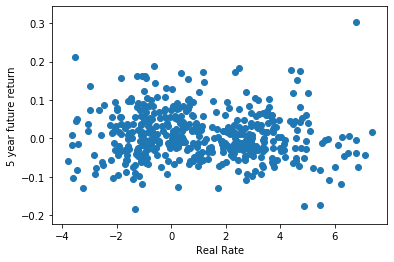

In [9]:
plt.scatter(df_fut['Real Rate'],df_fut['gold_fut_ret']);
plt.xlabel('Real Rate');
plt.ylabel('5 year future return');

## Normalized Gold price and future 5 year return

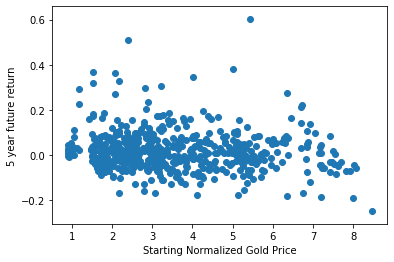

In [10]:
plt.scatter(df_fut['Normal Gold'],df_fut['gold_fut_ret']);
plt.xlabel('Starting Normalized Gold Price');
plt.ylabel('5 year future return');

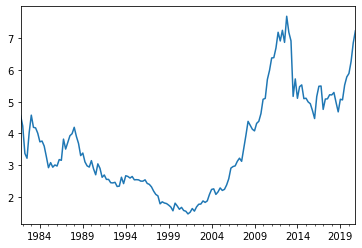

In [11]:
(df['Gold']/df['CPI']).plot()

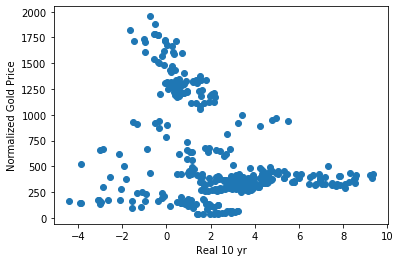

In [20]:
plt.scatter(df_fut['Real 10YR'],df_fut['Normal Gold']);
plt.xlabel('Real 10 yr');
plt.ylabel('Normalized Gold Price');

# Seasonality

Create function for monthly/daily segmentation for input data. Show boxplots for returns, vol and Sharpe 

### DAY

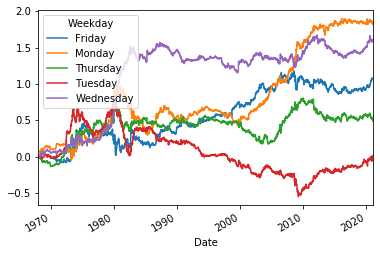

In [13]:
Gold_season_day = Gold_daily.copy()
Gold_season_day['Ret']= Gold_season_day['Gold'].pct_change(1)
Gold_season_day['Weekday']=Gold_season_day.index.weekday_name
Gold_season_day.reset_index().groupby(['Date','Weekday']).last()['Ret'].unstack().fillna(0).cumsum().plot();

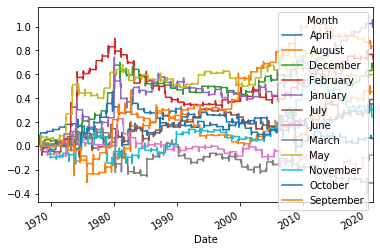

In [14]:
Gold_season_month = Gold_daily.copy()
Gold_season_month['Ret']= Gold_season_day['Gold'].pct_change(1)
Gold_season_month['Month']=Gold_season_day.index.month_name()
Gold_season_month["logret"] = Gold_season_month.groupby("Month")['Gold'].apply(lambda x: np.log(x) - np.log(x.shift()))


Gold_season_month.reset_index().groupby(['Date','Month']).last()['Ret'].unstack().fillna(0).cumsum().plot();

In [15]:
def seasonality(data, interval = 'Month', metric = 'Sharpe'):
    df = data.copy()
    df.columns = ['Price']
    df['Ret']= df['Price'].pct_change(1)
    if interval == 'Month':

        df['Month']=df.index.month_name()
        df["logret"] = df.groupby("Month")['Price'].apply(lambda x: np.log(x) - np.log(x.shift()))
    
        mean_df = df.reset_index().groupby(['Month'])['Ret'].mean()*252
        std_df = df.reset_index().groupby(['Month'])['Ret'].std()*np.sqrt(252)
    
        new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        mean_df = mean_df.reindex(new_order, axis=0)
        std_df = std_df.reindex(new_order, axis=0)
        sharpe_df = (mean_df)/(std_df)
    
    elif interval == 'Day':
        df['Day']=df.index.day_name()
        df["logret"] = df.groupby("Day")['Price'].apply(lambda x: np.log(x) - np.log(x.shift()))
        mean_df = df.reset_index().groupby(['Day'])['Ret'].mean()*252
        std_df = df.reset_index().groupby(['Day'])['Ret'].std()*np.sqrt(252)
        
        new_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        mean_df = mean_df.reindex(new_order, axis=0)
        std_df = std_df.reindex(new_order, axis=0)
        sharpe_df = (mean_df)/(std_df)
    
        
    if metric == 'Sharpe':
        l = sharpe_df.values.tolist()
        new_l = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, l) for i in b]
        plt.bar(sharpe_df.index.values.tolist(),new_l)
        plt.xticks(rotation=45)
    elif metric == 'Ret':
        l = mean_df.values.tolist()
        new_l = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, l) for i in b]
        plt.bar(mean_df.index.values.tolist(),new_l)
        plt.xticks(rotation=45)
        
    return
    

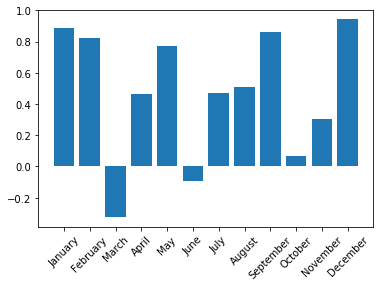

In [16]:
test = seasonality(Gold_daily, interval='Month', metric='Sharpe')

In [17]:
omx = yf.download('GLD')

[*********************100%***********************]  1 of 1 completed


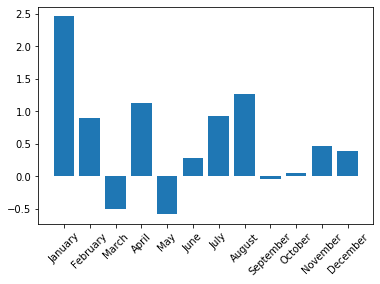

In [18]:
omx = pd.DataFrame(omx['Close'])
seasonality(omx,interval='Month', metric='Sharpe')

## Interest Rate Sensitivity

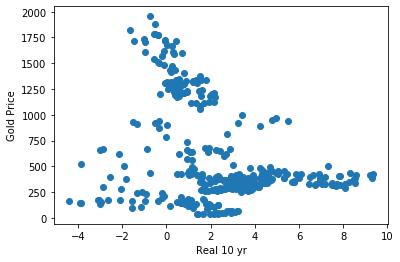

In [21]:
plt.scatter(df_fut['Real 10YR'],df_fut['Gold']);
plt.xlabel('Real 10 yr');
plt.ylabel('Gold Price');

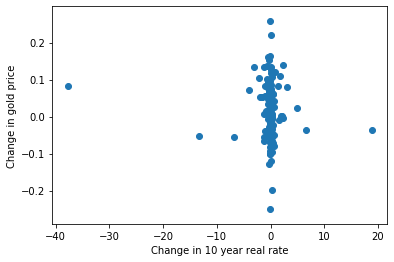

In [43]:
plt.scatter(df['Real 10yr'].pct_change(1).dropna(),df['Gold'].pct_change(1).dropna());
plt.xlabel('Change in 10 year real rate');
plt.ylabel('Change in gold price');

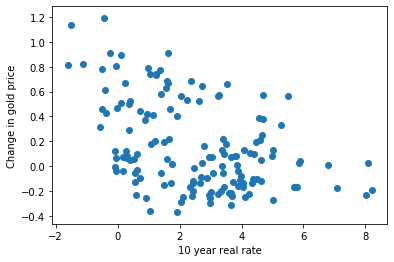

In [47]:
plt.scatter(df['Real 10yr'][12:].dropna(),df['Gold'].pct_change(12).dropna());
plt.xlabel('10 year real rate');
plt.ylabel('Change in gold price');


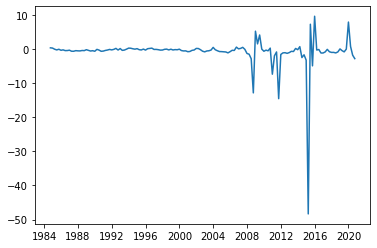

In [50]:
plt.plot(df['Real 10yr'].pct_change(12).dropna());